In [1]:
%matplotlib inline

# Module 13 - Programming Assignment

## Directions

1. Change the name of this file to be your JHED id as in `jsmith299.ipynb`. Because sure you use your JHED ID (it's made out of your name and not your student id which is just letters and numbers).
2. Make sure the notebook you submit is cleanly and fully executed. I do not grade unexecuted notebooks.
3. Submit your notebook back in Blackboard where you downloaded this file.

*Provide the output **exactly** as requested*

# The Problem

When we last left our agent in Module 4, it was wandering around a world filled with plains, forests, swamps, hills and mountains. This presupposes a map with known terrain:

```
......
...**.
...***
..^...
..~^..
```

but what if all we know is that we have some area of interest, that we've reduced to a GPS grid:

```
??????
??????
??????
??????
??????
```

and the agent has to determine what kind of terrain is to the left, front and right of it?

Assuming the agent has a very simple visual sensor that constructs a 4x4 grayscale image for each of the three directions, it might it could see something like this:

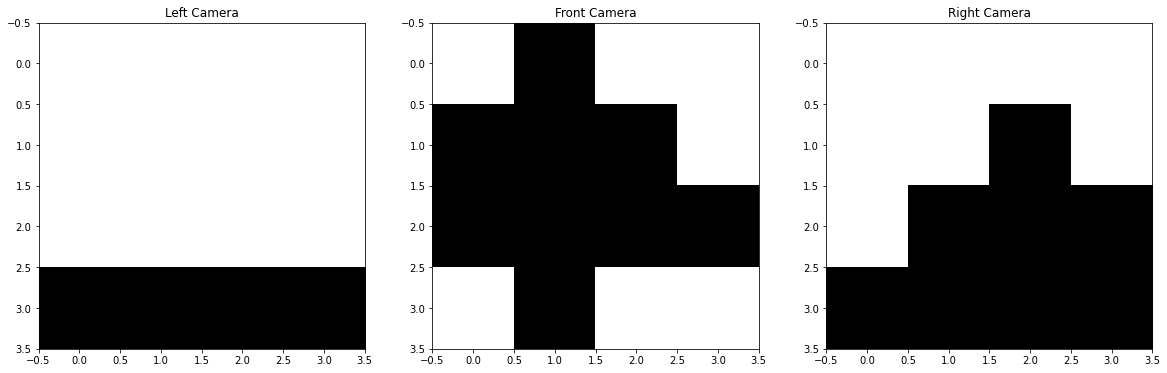

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

plain =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,1.0, 1.0, 1.0, 1.0]
forest = [0.0, 1.0, 0.0, 0.0,1.0, 1.0, 1.0, 0.0,1.0, 1.0, 1.0, 1.0,0.0, 1.0, 0.0, 0.0]
hills =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 1.0, 0.0,0.0, 1.0, 1.0, 1.0,1.0, 1.0, 1.0, 1.0]
swamp =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,1.0, 0.0, 1.0, 0.0,1.0, 1.0, 1.0, 1.0]

figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 3, 1)
pixels = np.array([255 - p * 255 for p in plain], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Left Camera")
axes.imshow(pixels, cmap='gray')

axes = figure.add_subplot(1, 3, 2)
pixels = np.array([255 - p * 255 for p in forest], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Front Camera")
axes.imshow(pixels, cmap='gray')

axes = figure.add_subplot(1, 3, 3)
pixels = np.array([255 - p * 255 for p in hills], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Right Camera")
axes.imshow(pixels, cmap='gray')

plt.show()
plt.close()

which would be plains, forest and hills respectively.


## The Assignment

In Assignment 12, we applied a logistic regression to determine if something was "hills" or "not hills". For this programming assignment your task is to write an artificial neural network that determines what kind of terrain it is. This is a multi-class problem.

For a starting point, you can refer to Pseudocode and the Self-Check.

## Data

As before, we have clean examples of the different types of terrain but based on the location, the registration can be a bit off for some of the types and the visual sensor is often blurry.

Here are the clean examples with different registrations: 

In [3]:
clean_data = {
    "plains": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, "plains"]
    ],
    "forest": [
        [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, "forest"],
        [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, "forest"]
    ],
    "hills": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, "hills"]
    ],
    "swamp": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "swamp"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, "swamp"]        
    ]
}

Let's create a function that allows us to view any of these:

In [4]:
def view_sensor_image( data):
    figure = plt.figure(figsize=(4,4))
    axes = figure.add_subplot(1, 1, 1)
    pixels = np.array([255 - p * 255 for p in data[:-1]], dtype='uint8')
    pixels = pixels.reshape((4, 4))
    axes.set_title( "Left Camera:" + data[-1])
    axes.imshow(pixels, cmap='gray')
    plt.show()
    plt.close()

"I think that I shall never see a thing so lovely as a tree."

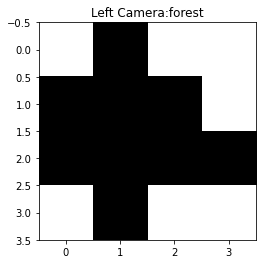

In [5]:
view_sensor_image( clean_data[ "forest"][0])

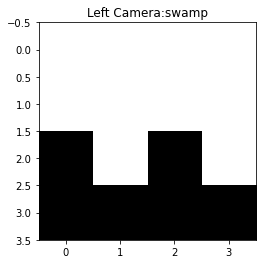

In [6]:
view_sensor_image( clean_data["swamp"][0])

The data that comes in, however, is noisy. The values are never exactly 0 and 1. In order to mimic this we need a `blur` function.

We will assume that noise is normally distributed. For values that should be 0, the noisy values are distributed $N(0.10, 0.05)$. For values should be 1, the noisy values are distributed $N(0.9, 0.10)$.

In [7]:
def blur( data):
    def apply_noise( value):
        if value < 0.5:
            v = random.gauss( 0.10, 0.05)
            if v < 0.0:
                return 0.0
            if v > 0.75:
                return 0.75
            return v
        else:
            v = random.gauss( 0.90, 0.10)
            if v < 0.25:
                return 0.25
            if v > 1.00:
                return 1.00
            return v
    noisy_readings = [apply_noise( v) for v in data[0:-1]]
    return noisy_readings + [data[-1]]

We can see how this affects what the agent *actually* sees.

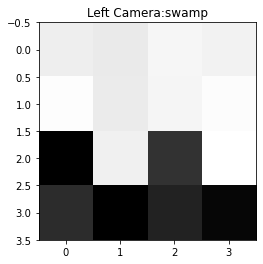

In [8]:
view_sensor_image( blur( clean_data["swamp"][0]))

In [9]:
blur( clean_data["swamp"][0])

[0.13992819103013804,
 0.07882106579017387,
 0.16749850638681643,
 0.018905550216034753,
 0.09675430153256012,
 0.22354440573908488,
 0.10285456410666129,
 0.12756446650264042,
 0.9569986605579277,
 0.15369567565197748,
 0.8066405592640903,
 0.16221648409722111,
 1.0,
 0.6810174324829089,
 0.9667032193901781,
 1.0,
 'swamp']

You are going to want to write four (4) functions:

1. `generate_data`
2. `learn_model`
3. `apply_model`

### `generate_data`

With the clean examples and the `blur` function, we have an unlimited amount of data for training and testing our classifier, an ANN that determines if a sensor image is hills, swamp, forest or plains.

In classification, there is a general problem called the "unbalanced class problem". In general, we want our training data to have the same number of classes for each class. This means you should probably generate training data with, say, 100 of each type.

But what do we do about the class label with the neural network?

In this case, we can do "one hot". Instead of `generate_data` outputing a single 0 or 1, it should output a vector of 0's and 1's so that $y$ is now a vector as well as $x$. We can use the first position for hill, the second for swamp, the third for forest and the fourth for plains:

```
[0, 1, 0, 0]
```

what am I? swamp.

Unlike logistic regression, you should set the *biases* inside the neural network (the implict $x_0$ = 1) because there are going to be lot of them (one for every hidden and output node).

`generate_data` now only needs to take how many you want of each class:

`generate_data( clean_data, 100)`

generates 100 hills, 100 swamp, 100 forest, 100 plains and transforms $y$ into the respective "one hot" encoding. You can use the code from Module 12 as a starting point.

### `learn_model`

`learn_model` is the function that takes in training data and actually learns the ANN. If you're up to it, you can implement a vectorized version using Numpy but you might start with the loopy version first.

*In the lecture, I mentioned that you usually should mean normalize your data but you don't need to do that in this case because the data is already on the range 0-1.*

You should add a parameter to indicate how many nodes the hidden layer should have.

When verbose is True, you should print out the error so you can see that it is getting smaller.

When developing your algorithm, you need to watch the error so you'll set verbose=True to start. You should print it out every iteration and make sure it is declining. You'll have to experiment with both epsilon and alpha; and it doesn't hurt to make alpha adaptive (if the error increases, make alpha = alpha / 10).

When you know that your algorithm is working, change your code so that the error is printed out only every 1,000 iterations (it takes a lot of iterations for this problem to converge, depending on your parameter values--start early).

`learn_model` returns the neural network. The hidden layer will be one vector of thetas for each hidden node. And the output layer will have its own thetas, one for each output (4 in this case). Return it as a Tuple: (List of List, List of List).

### `apply_model`

`apply_model` takes the ANN (the model) and either labeled or unlabeled data. If the data is unlabeled, it will return predictions for each observation as a List of Tuples of the inferred value (0 or 1) and the actual probability (so something like (1, 0.73) or (0, 0.19) so you have [(0, 0.30), (1, 0.98), (0, 0.87), (0, 0.12)]. Note that unlike the logistic regression, the threshold for 1 is not 0.5 but which value is largest (0.98 in this case).

If the data is labeled, you will return a List of List of Tuples of the actual value (0 or 1) and the predicted value (0 or 1). For a single data point, you'll have the pairs of actual values [(0, 1), (0, 0), (0, 0), (1, 0)] is a misclassification and [(0, 0), (0, 0), (1, 1), (0, 0)] will be a correct classification. Then you have a List of *those*, one for each observation.

###  simple evaluation

We have an "unlimited" supply of data so we'll just generate a training set and then a test set and see how well our neural network does. Use the error rate (incorrect classifications/total examples) for your evaluation metric. We'll learn about more sophisticated 

1. generate training set (how many do you think you need?)
2. generate test set (how many is a good "test" of the network you built?)
3. loop over [2, 4, 8] hidden nodes:
    1. train model and apply to train data, calculate error rate.
    2. apply to test data and calculate error rate.
    3. print error rate
    
Which number of hidden nodes did best?

**As always when working with Lists or Lists of Lists, be very careful when you are modifying these items in place that this is what you intend (you may want to make a copy first)**

---

Put your helper functions above here.

## Main Functions

### generate_data

Generates an endless supply of blurred data from a collection of terrain prototypes.

* `data`: Dict[Str, List[Any]] - a Dictionary of "clean" prototypes for each landscape type.
* `n`: Int - the number of blurred examples of each terrain type to return.

returns

* List[List[Any]] - a List of Lists. Each individual List is a blurred example of a terrain type, generated from the prototype.

In [10]:
def generate_data(data, n):
    sample_data = []
    encoder = {}
    encoding = [0 for surface in data.keys()]
    for i, surface in enumerate(data.keys()):
        
        # create encoding sample
        surface_encoding = encoding.copy()
        surface_encoding[i] = 1
        encoder[surface] = surface_encoding
        
        n_surface_samples = len(data[surface])
        if n_surface_samples>1:
            new_n = n//n_surface_samples + 1
            for s in data[surface]:
                for n_ in range(new_n):
                    sample_data.append([blur(s)[:-1],encoder[surface]])
        else:
            new_n = n
            for n_ in range(new_n):
                    sample_data.append([blur(data[surface][0])[:-1],encoder[surface]])
            
    return sample_data

In [11]:
n = 100
sample = generate_data(clean_data, 100)  
# The function generates a total of n * number of suface types in clean data
assert len(sample) >= len(clean_data)*n
# each observation has an observation and an encoding of the y
assert len(sample[0]) == 2

### learn_model

**put documentation here based on the assignment description**

#### `create_network(n_inputs, n_hidden_nodes, n_outputs)`
`create_network()` initializes the neural network. The neural network will have the initial components,
first it will have a hidden layer. The `hidden_layer` will be constructed taking into account the number of inputs `n_inputs` and the number of hidden nodes `n_hidden_nodes`. This because we need to initialize weights for every connection between `n_inputs` and `n_hidde_nodes`. Similarly, the `output_layer` will initialize weights connecting the number of `n_hidden_nodes` and the number of `n_outputs`. Notice that we are initializing using +1 as we are accounting for the bias of each node. The initalization will be random using the `random` module of the `random` package.

In [12]:
def create_network(n_inputs, n_hidden_nodes, n_outputs):
    network = list()
    hidden_layer = [{'weights':[random.random() for i in range(n_inputs + 1)]} for i in range(n_hidden_nodes)]
    network.append(hidden_layer)
    output_layer = [{'weights':[random.random() for i in range(n_hidden_nodes + 1)]} for i in range(n_outputs)]
    network.append(output_layer)
    return network

In [13]:
# we initialize a network with one input, two hidden layer nodes, and two outputs
sample_network = create_network(1, 2, 2)
# this node should have a hidden layer of length 2
assert len(sample_network[0]) == 2
# the first hidden layer node should have two weights, one for the connection to the input and one for the bias
assert len(sample_network[0][0]['weights']) == 2
# this first output layer should have three weights: one for each hidden layer node, and one for the bias
assert len(sample_network[1][0]['weights']) == 3

#### Forward Propagation

##### `activate(weights, inputs)`
The first step in the feed_forward sequence is to compute the activation function. The `activation()` function takes all the `weights` but the bias and multiplies it against the `inputs` 

In [14]:
def activate(weights, inputs):
    activation = weights[-1]
    for i in range(len(weights)-1):
        activation += weights[i] * inputs[i]
    return activation

In [15]:
weights = [0,0.5,0.5]
inputs = [1,2,1]
assert activate(weights, inputs) == 1.5

##### `transfer_function(activation)`
We will implement the sigmoid function of the form $f(x) = \frac{1}{1 + e^{x}}$ as in the lectures, `transfer_function()` therefore returns the sigmoid function for a given `activation` value.

In [16]:
from math import exp
def transfer_function(activation):
    return 1.0 / (1.0 + exp(-activation)) 

In [17]:
# Test of the transfer function for the values 0,1,2
assert transfer_function(0) == 0.5
assert transfer_function(1) == 0.7310585786300049
assert transfer_function(2) == 0.8807970779778823

##### `forward_propagate(network, row)`
During the forward propagation each layer from `network` is looped through
while calculating the outputs for each `neuron`. All inputs from one layer become inputs to the neurons at the next layer. The function `forward_propagate` performs this function with a couple of for loops.

In [18]:
def forward_propagate(network, row):
    inputs = row
    for layer in network:
        new_inputs = []
        for neuron in layer:
            activation = activate(neuron['weights'], inputs)
            neuron['output'] = transfer_function(activation)
            new_inputs.append(neuron['output'])
        inputs = new_inputs
    return inputs

In [19]:
n_outputs = 4
sample_network = create_network(2, 1, n_outputs)
output = forward_propagate(sample_network, [0,1])
assert len(output) == n_outputs

#### Backpropagation

##### transfer_derivative(output)
The transfer derivative of an output corresponds to $\text{transfer derivative} = output \times (1 - output)$

In [20]:
def transfer_derivative(output):
    return output * (1.0 - output)

In [21]:
assert transfer_derivative(0) == 0
assert transfer_derivative(1) == 0
assert transfer_derivative(2) == -2
assert transfer_derivative(3) == -6

##### `backward_propagate_error(network, expected)`
The error on a given output neuron is given by 
$$
error = (output - expected) * \text{transfer_derivative}(output)
$$
This error calculation is used for neurons in the output layer.
In the inner layer however, the error signal for a neuron is calculated as the weighted error of each neuron in the output layer. 
For a given $i$th neuron, the weight $j$ will connect the $j$th neuron to the current neuron. The function outputs the output of the current neuron as follows:
$$
error = (weight_i \times error_j) * \text{transfer_derivative}(output)
$$
The function `backward_propagate_error()` accumulates this error for a given `network` and a set of `expected` values. 

In [22]:
def backward_propagate_error(network, expected):
    for i in reversed(range(len(network))):
        layer = network[i]
        errors = list()
        if i != len(network)-1:
            for j in range(len(layer)):
                error = 0.0
                for neuron in network[i + 1]:
                    error += (neuron['weights'][j] * neuron['delta'])
                errors.append(error)
        else:
            for j in range(len(layer)):
                neuron = layer[j]
                errors.append(neuron['output'] - expected[j])
        for j in range(len(layer)):
            neuron = layer[j]
            neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])

In [23]:
network = [[{'output': 0.7105668883115941, 'weights': [0.13436424411240122, 0.8474337369372327, 0.763774618976614]}],
           [{'output': 0.6213859615555266, 'weights': [0.2550690257394217, 0.49543508709194095]}, {'output': 0.6573693455986976, 'weights': [0.4494910647887381, 0.651592972722763]}]]
expected = [0, 1]
backward_propagate_error(network, expected)
# each layer neuron should contain an output, a weight, and a delta value
for layer in network:
    for node in layer:
        assert 'output' in node.keys()
        assert 'weights' in node.keys()
        assert 'delta' in node.keys()

#### `update_network(network, row, l_rate)`
Next, we need to update the weights given the `delta` value produced in `backward_propagate_error`. `update_network(network, row, l_rate)` updates the weights for a `network` given an input `row` of data, a learning rate `l_rate` and assume that a forward and backward propagation have already been performed.

In [24]:
def update_weights(network, row, l_rate):
    for i in range(len(network)):
        inputs = row[:-1]
        if i != 0:
            inputs = [neuron['output'] for neuron in network[i - 1]]
        for neuron in network[i]:
            for j in range(len(inputs)):
                neuron['weights'][j] -= l_rate * neuron['delta'] * inputs[j]
            neuron['weights'][-1] -= l_rate * neuron['delta']

##### `learn_model( data, hidden_nodes, verbose=False, n_epoch=40, l_rate=0.5)`
The function `learn_model()` below implements stochastic gradient descent. The expected number of output values is used to transform class values in the training data into a one hot encoding. That is a binary vector with one column for each class value to match the output of the network. This is required to calculate the error for the output layer. The function involves first looping over a fixed number of epochs and within each epoch updating the network for each row in the training dataset. 

In [25]:
def learn_model( data, hidden_nodes, verbose=False, n_epoch=40, l_rate=0.5):
    x = [observation[0] for observation in data]
    y = [observation[1] for observation in data]
    n_inputs = len(x[0])
    n_outputs = len(y[0])
    network = create_network(n_inputs, hidden_nodes, n_outputs)
    for epoch in range(n_epoch):
        sum_error = 0
        for row in range(len(x)):
            outputs = forward_propagate(network, x[row])
            expected = y[row]
            sum_error += sum([(expected[i]-outputs[i])**2 for i in range(len(expected))])
            backward_propagate_error(network, expected)
            update_weights(network, x[row], l_rate)
        if verbose:
            print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))
    
    return network

In [26]:
sample = generate_data(clean_data, 100)
sample_network = learn_model( sample, 4, True)

>epoch=0, lrate=0.500, error=100.372
>epoch=1, lrate=0.500, error=116.032
>epoch=2, lrate=0.500, error=115.980
>epoch=3, lrate=0.500, error=115.528
>epoch=4, lrate=0.500, error=113.896
>epoch=5, lrate=0.500, error=105.659
>epoch=6, lrate=0.500, error=95.214
>epoch=7, lrate=0.500, error=88.680
>epoch=8, lrate=0.500, error=84.267
>epoch=9, lrate=0.500, error=79.035
>epoch=10, lrate=0.500, error=69.850
>epoch=11, lrate=0.500, error=59.028
>epoch=12, lrate=0.500, error=50.866
>epoch=13, lrate=0.500, error=45.201
>epoch=14, lrate=0.500, error=41.021
>epoch=15, lrate=0.500, error=37.377
>epoch=16, lrate=0.500, error=33.914
>epoch=17, lrate=0.500, error=30.612
>epoch=18, lrate=0.500, error=27.565
>epoch=19, lrate=0.500, error=24.794
>epoch=20, lrate=0.500, error=22.245
>epoch=21, lrate=0.500, error=19.905
>epoch=22, lrate=0.500, error=17.794
>epoch=23, lrate=0.500, error=15.996
>epoch=24, lrate=0.500, error=14.495
>epoch=25, lrate=0.500, error=13.216
>epoch=26, lrate=0.500, error=12.117
>epoc

### apply_model

**put documentation here based on the assignment description**

#### `predict_class(model,row)`
`predict_class(model,row)` implements `forward_propagate()` from the already trained model into the test dataset. This would generate results for which the arg max value is given the classification. 

In [27]:
def predict_class(model, row):
    output = forward_propagate(sample_network, row)
    predicted_class = output.index(max(output))
    prediction = [(1 if i == predicted_class else 0, output[i]) for i in range(len(output))]
    return prediction

#### `apply_model(model, data, labeled= False)`
Implements the function as specified in the statement. It loops over the observations in the data to produce predictions using the `predict_class()` function above. If `labeled` is True, then a direct comparison against the provided expected value is produced as the tuple value pair, otherwise a probability is provided as a tuple value pair.

In [28]:
def apply_model(model, data, labeled= False):
    x = [observation[0] for observation in data]
    y_hat = []
    for row in range(len(data)):
        y_hat.append(predict_class(model, x[row]))
    if labeled:
        comparison = []
        y = [observation[1] for observation in data]
        for row in range(len(y)):
            comparison.append([(y[row][label],y_hat[row][label][0]) for label in range(len(y[row]))])
        return comparison
    else:
        return y_hat

Test out generate_data:

In [29]:
results = generate_data( clean_data, 10)
for result in results:
    print( result)

[[0.0791438574480991, 0.07870481547524914, 0.047950231397511436, 0.18752796867983088, 0.13138220118540853, 0.06717740913029105, 0.06610457578327616, 0.05473720920276186, 0.04486137652846586, 0.09528443211704873, 0.05525179686042726, 0.04361313261071989, 1.0, 0.9141770334360152, 0.8621936137941624, 0.8949425029229924], [1, 0, 0, 0]]
[[0.0328150225610402, 0.10437056838427161, 0.029736138758240424, 0.0828142490922946, 0.007018348526731208, 0.18255030646080528, 0.18917133072378098, 0.05002854976132768, 0.12257799504803099, 0.10661615142073326, 0.11968406387110633, 0.03604687117395361, 0.7089347601002686, 0.9902763133398701, 0.8248994929862445, 0.9765765289469768], [1, 0, 0, 0]]
[[0.13721136905956619, 0.13830414125775606, 0.07911380332709517, 0.06860846716487734, 0.10094746713339561, 0.10703446080744165, 0.016997559310813926, 0.005548335643702482, 0.10550811808461666, 0.06110927641983832, 0.1075847105479499, 0.019273747503133126, 0.8266611805199703, 1.0, 0.6804921391691294, 0.96349585794945

Use `generate_data` to generate 100 blurred examples of each type (all four terrains).

In [30]:
train_data = generate_data( clean_data, 100)

Use `learn_model` to learn a ANN model for classifying sensor images as hills, swamps, plains or forest. **Set Verbose to True**

In [31]:
model = learn_model( train_data, 10, True)

>epoch=0, lrate=0.500, error=185.480
>epoch=1, lrate=0.500, error=81.251
>epoch=2, lrate=0.500, error=81.404
>epoch=3, lrate=0.500, error=80.685
>epoch=4, lrate=0.500, error=79.396
>epoch=5, lrate=0.500, error=77.219
>epoch=6, lrate=0.500, error=74.388
>epoch=7, lrate=0.500, error=71.191
>epoch=8, lrate=0.500, error=67.488
>epoch=9, lrate=0.500, error=63.373
>epoch=10, lrate=0.500, error=59.291
>epoch=11, lrate=0.500, error=55.398
>epoch=12, lrate=0.500, error=51.721
>epoch=13, lrate=0.500, error=48.393
>epoch=14, lrate=0.500, error=45.497
>epoch=15, lrate=0.500, error=43.036
>epoch=16, lrate=0.500, error=40.989
>epoch=17, lrate=0.500, error=39.248
>epoch=18, lrate=0.500, error=37.634
>epoch=19, lrate=0.500, error=35.845
>epoch=20, lrate=0.500, error=33.551
>epoch=21, lrate=0.500, error=30.862
>epoch=22, lrate=0.500, error=28.151
>epoch=23, lrate=0.500, error=25.433
>epoch=24, lrate=0.500, error=22.693
>epoch=25, lrate=0.500, error=20.111
>epoch=26, lrate=0.500, error=17.770
>epoch=27,

Use `generate_data` to generate 100 blurred examples of each terrain and use this as your test data.

In [32]:
test_data = generate_data( clean_data, 100)

Apply the model and evaluate the results.

In [33]:
results = apply_model( model, test_data,False)
print('Labeled is False')
print(results[:5])


print('\nLabeled is True')
results = apply_model( model, test_data,True)
print(results[:5])


Labeled is False
[[(1, 0.9084647430747597), (0, 4.507782191901658e-05), (0, 0.0735083765330385), (0, 0.17137325607128281)], [(1, 0.9504439925593112), (0, 3.0877212242421666e-05), (0, 0.13846081723290096), (0, 0.07154558136254616)], [(1, 0.9334329621754337), (0, 3.7808459053354616e-05), (0, 0.11391169588740958), (0, 0.09879092266717796)], [(1, 0.9171758648155078), (0, 4.2764759333320396e-05), (0, 0.08238602765963231), (0, 0.14892103691510483)], [(1, 0.9175432723873012), (0, 4.1701472765342526e-05), (0, 0.08081416604678998), (0, 0.14879788429918073)]]

Labeled is True
[[(1, 1), (0, 0), (0, 0), (0, 0)], [(1, 1), (0, 0), (0, 0), (0, 0)], [(1, 1), (0, 0), (0, 0), (0, 0)], [(1, 1), (0, 0), (0, 0), (0, 0)], [(1, 1), (0, 0), (0, 0), (0, 0)]]


print( results)

Now that you're pretty sure your algorithm works (the error rate during training is going down, and you can evaluate `apply_model` results for its error rate), you need to determine what the best number of hidden nodes is.

Try 2, 4, or 8 hidden nodes and indicate the best one. Follow the outline above under "Simple Evaluation".
In the "real world", you could 10 fold cross validation and validation curves to determine the number of hidden nodes and possibly if you needed one or two hidden layers.

##### `error_rate()`
Provided the formatting of the results data, the `error_rate` function scans through the list of tuples for each observation. Whenever a component of the tuples is different from the other, that observation is counted as an error. The error rate is the result of that count divided by the total observations in the `results`.

In [34]:
def error_rate(results):
    errors = 0 
    for result in results:
        for lable in result:
            if lable[0] != lable[1]:
                errors += 1
                break
    return errors/len(results)

In [35]:
epochs = 30
l_rate = 0.5
nodes_label = 'Nodes'
train_label = 'Training (%)'
test_label = 'Test (%)'
print('Error Rate on Training and Test Data')
print(f'at {epochs} epochs and a learning rate of {l_rate} \n')
print(f"""{nodes_label : <5}{train_label : ^15}\
    {test_label : >6}""")

train_data = generate_data(clean_data, 200)
random.shuffle(train_data)
test_data = generate_data(clean_data, 40)
random.shuffle(test_data)
for hidden_nodes in range(2,9):
    
    model=None
    train_error = 0
    test_error = 0
    
    model = learn_model( train_data, hidden_nodes, False, n_epoch = epochs, l_rate=l_rate)
    
    train_results = apply_model(model, train_data,True)
    train_error = error_rate(train_results)*100
    
    test_results = apply_model(model, test_data,True)
    test_error = error_rate(test_results)*100
    
    print(f"""{hidden_nodes : <5}{train_error : ^15.4f}\
    {test_error : >6.4f}""")
    

Error Rate on Training and Test Data
at 30 epochs and a learning rate of 0.5 

Nodes Training (%)      Test (%)
2        9.2593         9.4118
3        9.2593         9.4118
4        9.2593         9.4118
5        9.2593         9.4118
6        9.2593         9.4118
7        9.2593         9.4118
8        9.2593         9.4118


which number of hidden nodes is best? ____

**After trying different combinations and variables, holding the same amount of epochs and learning rate while changing the number of nodes in the internal layer does not seem to have a hugely significant impact. It is the case that the error rate decreases as the number of nodes in the internal layer increases. However, changing the learning rate increases the speed at which the algorithm converges. Increasing the amount of epochs increases the ability the algorithm has to improve accuracy.**

## Before You Submit...

1. Did you provide output exactly as requested?
2. Did you re-execute the entire notebook? ("Restart Kernel and Rull All Cells...")
3. If you did not complete the assignment or had difficulty please explain what gave you the most difficulty in the Markdown cell below.
4. Did you change the name of the file to `jhed_id.ipynb`?

Do not submit any other files.